I made some notes about this on pg 90 of the lab notebook (18-12-2024) \[KCM\]

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy.interpolate as si
from scipy import signal

#constants
#blue = '#118DFA' #unused

# Si HV Neutron Data

In [2]:
#silicon HV data for neutrons
si_data = pd.read_csv('papers/sensitivity_data/silicon_HV_neutron_full.txt', skiprows=1, \
                         names=['recoilE', 'rate'])
print (si_data.head(100)) #preview some entries

si_erec = np.asarray(si_data["recoilE"],dtype=float) #Si recoil energy
si_rate = np.asarray(si_data["rate"])                #associated rate
#Reformat data -- data stored on log scale
si_erec = 10**si_erec 
si_rate = 10**si_rate

    recoilE    rate
0   -1.3887 -0.4070
1   -1.3887 -0.3833
2   -1.3824 -0.3596
3   -1.3761 -0.3357
4   -1.3699 -0.3357
..      ...     ...
95  -1.1818 -0.6175
96  -1.1755 -0.5937
97  -1.1755 -0.5701
98  -1.1693 -0.5464
99  -1.1693 -0.5227

[100 rows x 2 columns]


In [3]:
#smooth the data - filter 3x
si_rate_smooth = signal.savgol_filter(si_rate, 400, 2) # window size 501, polynomial order 3

def smooth(y, box_pts): 
    box = np.ones(box_pts)/box_pts #make n points each equal to 1/n
    y_smooth = np.convolve(y, box, mode='same') #discrete linear convolution that keeps all points
    return y_smooth

si_rate_smooth2 = smooth(si_rate,400)
si_rate_smooth3 = smooth(si_rate_smooth2,200)

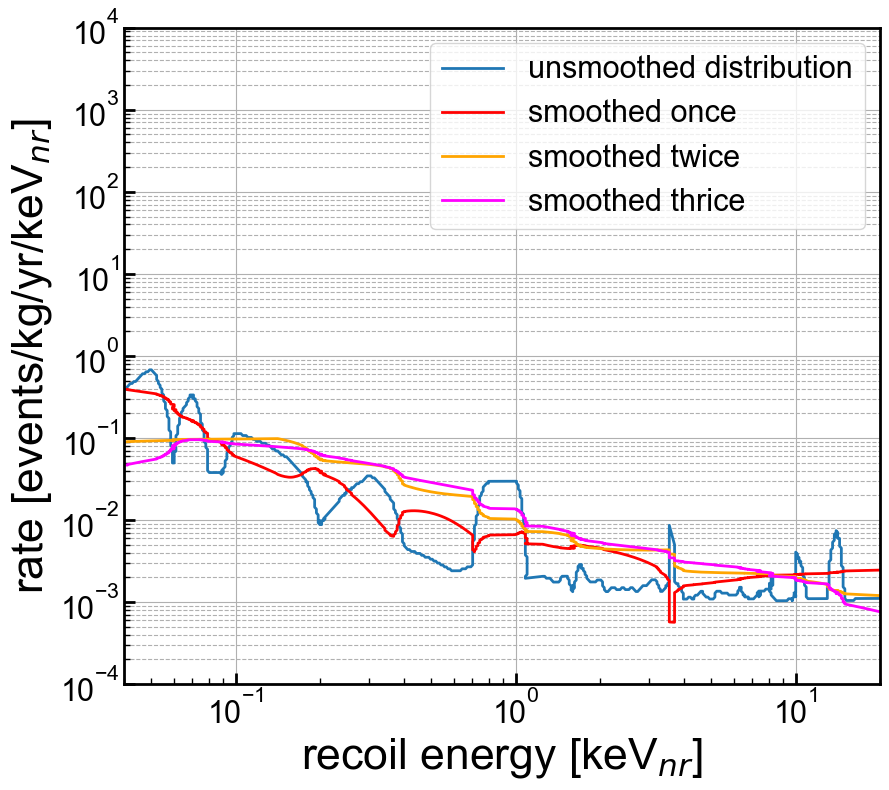

In [4]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

# Plot the data
ax1.plot(si_erec, si_rate,label="unsmoothed distribution")
ax1.plot(si_erec, si_rate_smooth,color='r',label="smoothed once")
ax1.plot(si_erec, si_rate_smooth2,color='orange',label="smoothed twice")
ax1.plot(si_erec, si_rate_smooth3,color='magenta',label="smoothed thrice")

#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

#Plot formatting
plt.loglog()
plt.grid()
ax1.set_xlim(4e-2, 2e1) 
ax1.set_ylim(1e-4,1e4)
ax1.set_xlabel(r'recoil energy [keV$_{nr}$]')
ax1.set_ylabel('rate [events/kg/yr/keV$_{nr}$]')
ax1.yaxis.grid(True,which='minor',linestyle='--') #add the minor grid lines in -- major already present
ax1.legend(loc=1,prop={'size':22}) #bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
plt.tight_layout()

#Save & show
plt.savefig('figures/scdms_si_nrate.png')
plt.show()

Interesting how the point at x~2.5 inverts on the first smooth but is fixed by the second.

# Ge HV Neutron Data

In [5]:
#germanium HV data for neutrons
ge_data = pd.read_csv('papers/sensitivity_data/germanium_HV_neutron_full.txt', skiprows=1, \
                         names=['recoilE', 'rate'])
print (ge_data.head(100))

ge_erec = np.asarray(ge_data["recoilE"],dtype=float) #Ge recoil energies
ge_rate = np.asarray(ge_data["rate"])
ge_erec = 10**ge_erec
ge_rate = 10**ge_rate

    recoilE    rate
0   -1.3829 -0.8509
1   -1.3766 -0.8511
2   -1.3703 -0.8513
3   -1.3639 -0.8515
4   -1.3576 -0.8517
..      ...     ...
95  -1.0363 -1.5649
96  -1.0426 -1.5647
97  -1.0489 -1.5645
98  -1.0426 -1.5647
99  -1.0363 -1.5356

[100 rows x 2 columns]


In [6]:
#smooth the data
ge_rate_smooth = signal.savgol_filter(ge_rate, 400, 2) # window size 501, polynomial order 3
ge_rate_smooth2 = smooth(ge_rate,400)
ge_rate_smooth3 = smooth(ge_rate_smooth2,200)

sos = signal.butter(4, 1, 'low', analog=True,output='sos') #filter model
ge_rate_smooth_butter = signal.sosfilt(sos, ge_rate)             #actual filtering -- also note that this is only 1 filter, it's not stacked on top of smooth3

In [7]:
#try peak finding
ge_rate_smooth_forpeaks = signal.savgol_filter(ge_rate, 30, 3)
peaks, _ = signal.find_peaks(ge_rate_smooth_forpeaks, distance=30)
antipeaks, _ = signal.find_peaks(-ge_rate_smooth_forpeaks, distance=30)
print(peaks)
print(antipeaks)

#Find the rates at maxima and minima
ge_rate_up = signal.savgol_filter(ge_rate_smooth_forpeaks[peaks], 5, 3)
ge_rate_dn = signal.savgol_filter(ge_rate_smooth_forpeaks[antipeaks], 5, 3)
print(ge_rate_up)
print(ge_rate_dn)

[  7  64 117 188 244 297 356 406 453]
[ 44  90 164 265 328 381 437 473]
[0.14551533 0.08007995 0.0578827  0.0376945  0.01258365 0.00486394
 0.00681581 0.00561891 0.00173337]
[0.02868029 0.02489315 0.01672255 0.00808631 0.00105311 0.00137833
 0.00147308 0.00093646]


In [8]:
#interpolate to generate an envelope around Ge data
cs_up = si.PchipInterpolator(ge_erec[peaks], ge_rate_smooth_forpeaks[peaks])
cs_dn = si.PchipInterpolator(ge_erec[antipeaks], ge_rate_smooth_forpeaks[antipeaks])

On this interpolation --
basically, if we interpolate the peaks everything should be at most at those points, and vice versa.
It doesn't have a particular uncertainty, but uncertainties are not provided within the data,
so the best we can say is "the data is somewhere within this envelope."

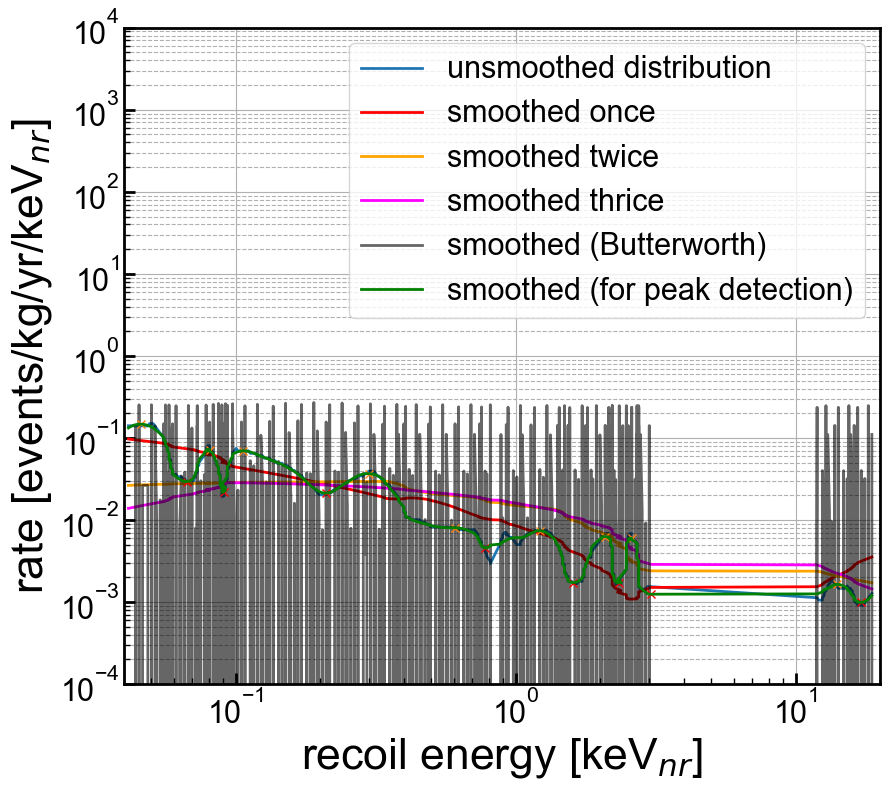

In [9]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

#print(estring)
ax1.plot(ge_erec, ge_rate,label='unsmoothed distribution')
ax1.plot(ge_erec, ge_rate_smooth,color='r',label="smoothed once")
ax1.plot(ge_erec, ge_rate_smooth2,color='orange',label="smoothed twice")
ax1.plot(ge_erec, ge_rate_smooth3,color='magenta',label="smoothed thrice")
ax1.plot(ge_erec, ge_rate_smooth_butter,color='k',label="smoothed (Butterworth)",alpha=0.6)
ax1.plot(ge_erec[peaks], ge_rate_smooth_forpeaks[peaks], "x")
ax1.plot(ge_erec[antipeaks], ge_rate_smooth_forpeaks[antipeaks], "x",color='r')
ax1.plot(ge_erec, ge_rate_smooth_forpeaks,color='g',label="smoothed (for peak detection)")

plt.loglog()
plt.grid()
ax1.set_xlim(4e-2, 2e1) 
ax1.set_ylim(1e-4,1e4)
ax1.set_xlabel(r'recoil energy [keV$_{nr}$]')
ax1.set_ylabel('rate [events/kg/yr/keV$_{nr}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
plt.tight_layout()

plt.savefig('figures/scdms_ge_nrate.png')
plt.show()

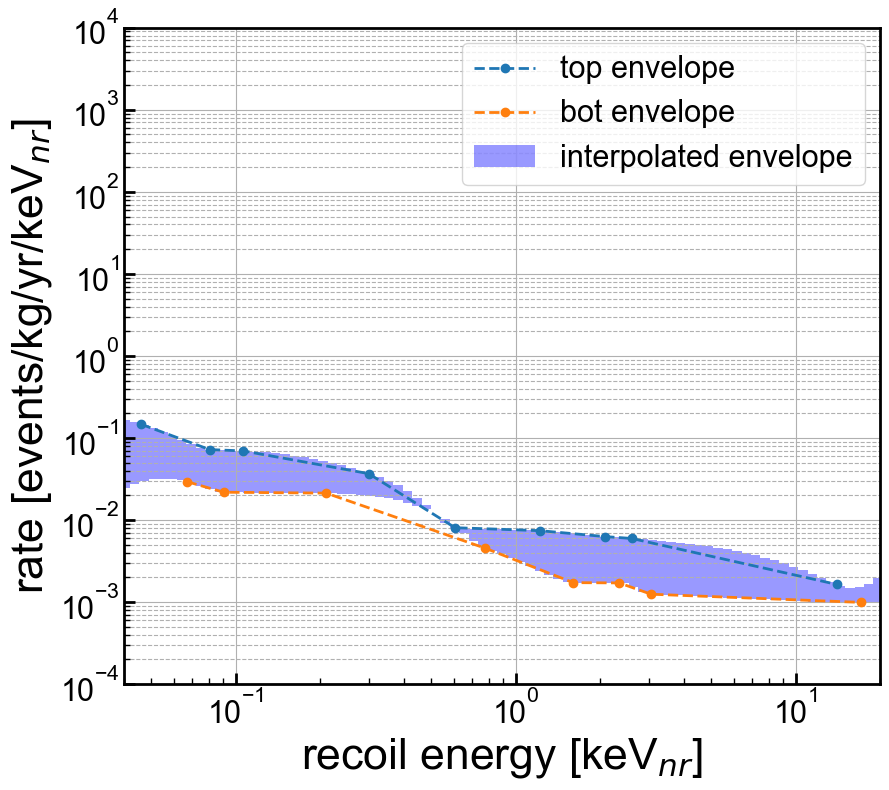

In [10]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

erange = np.logspace(-2,2,120)

ax1.plot(ge_erec[peaks], ge_rate_smooth_forpeaks[peaks],label='top envelope',marker='o',linestyle='--')
ax1.plot(ge_erec[antipeaks], ge_rate_smooth_forpeaks[antipeaks],label='bot envelope',marker='o',linestyle='--')
ax1.fill_between(erange,cs_up(erange),cs_dn(erange),step='mid',facecolor='b',alpha=0.4,
                 label='interpolated envelope')

plt.loglog()
plt.grid()
ax1.set_xlim(4e-2, 2e1) 
ax1.set_ylim(1e-4,1e4)
ax1.set_xlabel(r'recoil energy [keV$_{nr}$]')
ax1.set_ylabel('rate [events/kg/yr/keV$_{nr}$]')
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
plt.tight_layout()

plt.savefig('figures/scdms_ge_envelope.png')
plt.show()